In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('../das3_quat_abd.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptQuat'
start = tm.time()
MM,FO,TE,q,w,u0,fr,frstar,kinematical,xdot,holonomic,activations = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')
time_to_create = tm.time() - start
print(time_to_create)

515.306969165802


In [3]:
import equations as eq
reload (eq);
# dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondQuat'].item()
x0t = list(x0.T[0])

In [4]:
eoms_implicit = sp.Matrix(kinematical).col_join(fr+frstar+TE).col_join(holonomic)

In [5]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motion/abduciton/abd_struct.mat'
traj, interval_value, time, _ = tr.exp_trajectory_quat(file,num_nodes)

state_symbols = tuple(q+w+u0)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [6]:
traj_w = 250
vel_w = 10
act_w = 20


def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj - free[:13*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[13*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:13*num_nodes] = traj_w * 2.0 * interval_value * (free[:13*num_nodes] - traj)
    grad[13*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[13*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [7]:
instance_constraints = []
# for i in range(13):
instance_constraints.append(state_symbols[12].func(0.0)-x0t[12]) 
    
bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [8]:
start = tm.time()
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint')


time_to_create = tm.time() - start
print(time_to_create)



1538.630842924118


In [9]:

prob.add_option('max_iter',10000)
prob.add_option('limited_memory_max_history', 40)

In [10]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:13*num_nodes] = traj

In [11]:
solution, info = prob.solve(initial_guess)
print(info['status_msg'])
print(info['obj_val'])

b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
12.77915975914785


In [12]:
print(info['status_msg'])
print(info['obj_val'])

b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
12.77915975914785


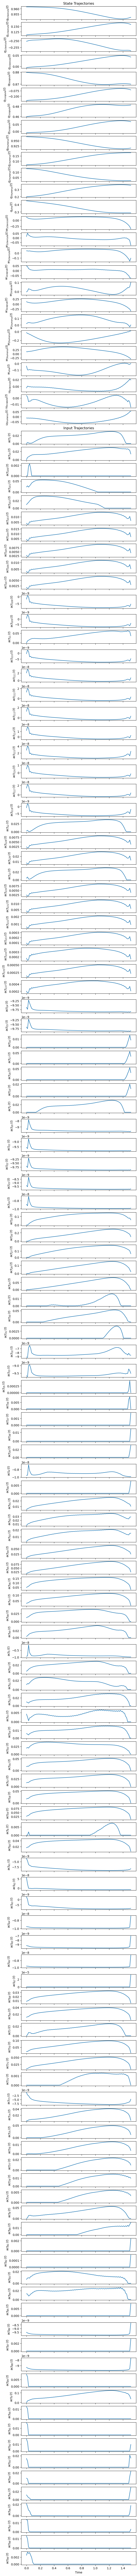

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

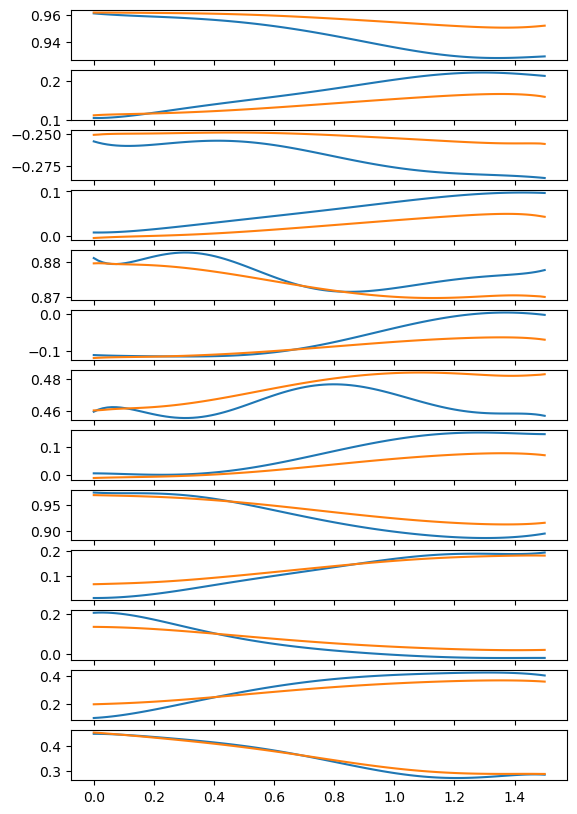

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(13)
for j in range(13):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [16]:
import trajectory_lib as tr
reload (tr);
file_name = '../quat_abd.mat'
tr.quat2matfile(solution,activations,len(q),num_states,num_nodes,time,file_name)

Saved to .mat file


In [30]:
import trajectory_lib as tr
reload (tr);

file_name_mot = '../quat_abd.mot'
tr.sol2mot_quat(solution,num_nodes,13,time,file_name_mot)

Saved to .mot file


array([[ 0.96172538,  0.11113579, -0.25041657, ...,  0.13503607,
         0.20012104,  0.45216871],
       [ 0.96169896,  0.1118498 , -0.25021065, ...,  0.13478764,
         0.20105213,  0.45112042],
       [ 0.96170532,  0.11240623, -0.24994459, ...,  0.13444907,
         0.20202669,  0.44962741],
       ...,
       [ 0.9515492 ,  0.16212625, -0.25721745, ...,  0.01913753,
         0.36213946,  0.28783491],
       [ 0.95184105,  0.1607128 , -0.25729083, ...,  0.01945497,
         0.36053205,  0.28764461],
       [ 0.9521462 ,  0.15877897, -0.25763973, ...,  0.01991572,
         0.35858435,  0.28754626]])

In [24]:
len(q)

13